# CoLeaf CNN

## Imports and configurations

In [37]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from network import Net
import torch.optim as optim
import torch.nn as nn
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torcheval.metrics import MulticlassConfusionMatrix, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

from trainer import CoLeafTrainer
from dataset import CoLeafDataset


In [2]:
IMG_SIZE        = 224
BATCH_SIZE      = 32
WORKERS         = 4
TRAIN_SPLIT     = 0.6
EPOCHS          = 50
LR              = 0.001
MODEL_VERSION   = "v1"
DATASET_PATH    = "./CoLeaf DATASET"
OUTPUT_PATH     = "./output"
MODEL_PATH      = f"./output/model_{MODEL_VERSION}.pth"

In [3]:
os.makedirs(OUTPUT_PATH, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## Loading dataset

In [25]:
dataset = CoLeafDataset(
    data_dir=DATASET_PATH,
    transform=transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),          
        transforms.ToTensor(),           
        transforms.Normalize(            
            mean=[0.5, 0.5, 0.5], 
            std=[0.5, 0.5, 0.5]
        )
    ])
)

torch.save(dataset, os.path.join(OUTPUT_PATH, "dataset.pt"))

Loading classes:   0%|          | 0/10 [00:00<?, ?it/s]

Loading images for class boron-B:   0%|          | 0/101 [00:00<?, ?it/s]

Loading images for class calcium-Ca:   0%|          | 0/162 [00:00<?, ?it/s]

Loading images for class healthy:   0%|          | 0/6 [00:00<?, ?it/s]

Loading images for class iron-Fe:   0%|          | 0/65 [00:00<?, ?it/s]

Loading images for class magnesium-Mg:   0%|          | 0/79 [00:00<?, ?it/s]

Loading images for class manganese-Mn:   0%|          | 0/83 [00:00<?, ?it/s]

Loading images for class more-deficiencies:   0%|          | 0/104 [00:00<?, ?it/s]

Loading images for class nitrogen-N:   0%|          | 0/64 [00:00<?, ?it/s]

Loading images for class phosphorus-P:   0%|          | 0/246 [00:00<?, ?it/s]

Loading images for class potasium-K:   0%|          | 0/96 [00:00<?, ?it/s]

In [ ]:
# Load the dataset object. Set `weights_only=False` as we trust the source of the file.
dataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/dataset.pt"), weights_only=False)

In [5]:
classes = dataset.classes
print(classes)

['boron-B', 'calcium-Ca', 'healthy', 'iron-Fe', 'magnesium-Mg', 'manganese-Mn', 'more-deficiencies', 'nitrogen-N', 'phosphorus-P', 'potasium-K']


In [6]:
# Split the dataset into train, validation, and test sets (60/20/20)
range_train, range_temp = train_test_split(
    range(len(dataset)),
    train_size=TRAIN_SPLIT,
    stratify=dataset.labels
)
range_valid, range_test = train_test_split(
    range_temp,
    test_size=0.5,
    stratify=[dataset.labels[i] for i in range_temp]
)

train_dataset = Subset(dataset, range_train)
val_dataset = Subset(dataset, range_valid)
test_dataset  = Subset(dataset, range_test)

In [ ]:
torch.save(train_dataset, os.path.join(OUTPUT_PATH, "datasets/train_dataset.pt"))
torch.save(val_dataset, os.path.join(OUTPUT_PATH, "datasets/val_dataset.pt"))
torch.save(test_dataset, os.path.join(OUTPUT_PATH, "datasets/test_dataset.pt"))

In [ ]:
train_dataset = torch.load(os.path.join(OUTPUT_PATH, "datsets/train_dataset.pt"), weights_only=False)
val_dataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/val_dataset.pt"), weights_only=False)
test_dataset = torch.load(os.path.join(OUTPUT_PATH, "datasets/test_dataset.pt"), weights_only=False)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS, pin_memory=True)
val_loader  = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

## Training

In [8]:
net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

In [ ]:
trainer = CoLeafTrainer(
    model=net,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
)

trainer.train()
trainer.save_model(MODEL_PATH)
train_metrics = pd.DataFrame(trainer.metrics)
train_metrics.to_csv(os.path.join(OUTPUT_PATH, f"metrics/train_metrics_{MODEL_VERSION}.csv"), header=True, sep=';')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

## Output visualization


In [ ]:
train_metrics = pd.read_csv(os.path.join(OUTPUT_PATH, f"metrics/train_metrics_{MODEL_VERSION}.csv"), sep=';')

### Model loss and accuracy

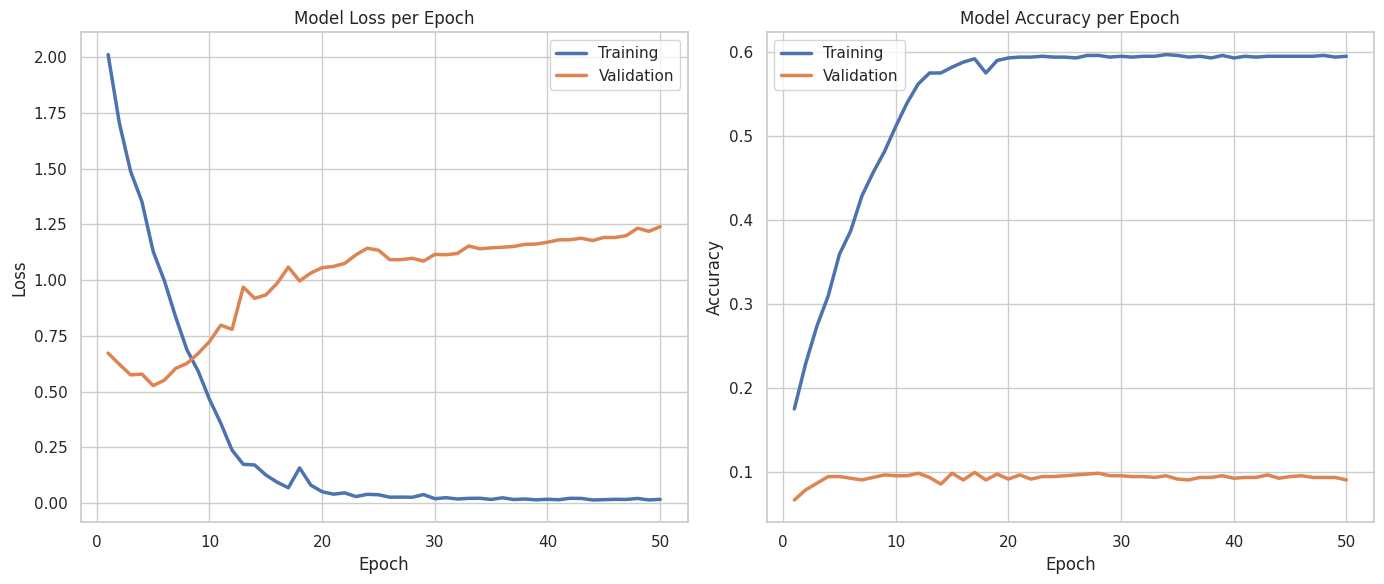

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.set_theme(style="whitegrid")

df_loss_wide = train_metrics.loc[:, ['train_loss', 'val_loss']]
df_loss_wide.columns = ['Training', 'Validation']
df_loss_wide['Epoch'] = df_loss_wide.index + 1

df_loss= pd.melt(
    df_loss_wide,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Type',
    value_name='Loss'
)

sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Type', linewidth=2.5, ax=axes[0])
axes[0].set_title('Model Loss per Epoch')
axes[0].legend(title='')

df_acc_wide = train_metrics.loc[:, ['train_acc', 'val_acc']]
df_acc_wide.columns = ['Training', 'Validation']
df_acc_wide['Epoch'] = df_acc_wide.index + 1
df_acc = pd.melt(
    df_acc_wide,
    id_vars=['Epoch'],
    value_vars=['Training', 'Validation'],
    var_name='Type',
    value_name='Accuracy'
)

sns.lineplot(data=df_acc, x='Epoch', y='Accuracy', hue='Type', linewidth=2.5, ax=axes[1])
axes[1].set_title('Model Accuracy per Epoch')
axes[1].legend(title='')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/model_performance_{MODEL_VERSION}.png"))
plt.show()

## Testing

In [31]:
net = Net().to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
metrics = {
    'cm': MulticlassConfusionMatrix(num_classes=len(classes)),
    'average_f1': MulticlassF1Score(num_classes=len(classes), average='micro'),
    'f1': MulticlassF1Score(num_classes=len(classes), average=None), 
    'average_precision': MulticlassPrecision(num_classes=len(classes), average='micro'), 
    'precision': MulticlassPrecision(num_classes=len(classes), average=None),
    'average_recall': MulticlassRecall(num_classes=len(classes), average='micro'),
    'recall': MulticlassRecall(num_classes=len(classes), average=None), 
}

for metric in metrics.values(): 
    metric.reset()

net.eval()

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        
        for metric in metrics.values(): 
            metric.update(predicted, labels)
            
cm = metrics['cm'].compute().cpu().numpy()
avg_precision = metrics['average_precision'].compute().item()
avg_recall = metrics['average_recall'].compute().item()
avg_f1 = metrics['average_f1'].compute().item()

class_data = {
    'f1': metrics['f1'].compute().cpu().numpy(),
    'precision': metrics['precision'].compute().cpu().numpy(),
    'recall': metrics['recall'].compute().cpu().numpy()
}

df_metrics = pd.DataFrame(class_data, index=classes)
df_metrics.loc['average'] = [avg_f1, avg_precision, avg_recall]

In [50]:
df_metrics.round(4).to_csv(os.path.join(OUTPUT_PATH, f"metrics/classification_report_{MODEL_VERSION}.csv"), sep=';')
np.save(os.path.join(OUTPUT_PATH, f"metrics/confusion_matrix_{MODEL_VERSION}.npy"), cm)

### Classification report

In [ ]:
df_metrics = pd.read_csv(os.path.join(OUTPUT_PATH, f"metrics/classification_report_{MODEL_VERSION}.csv"), sep=';')

In [51]:
display(df_metrics)

,f1,precision,recall
boron-B,0.421053,0.444444,0.400000
calcium-Ca,0.545455,0.545455,0.545455
healthy,0.000000,0.000000,0.000000
iron-Fe,0.160000,0.166667,0.153846
magnesium-Mg,0.250000,0.250000,0.250000
manganese-Mn,0.307692,0.260870,0.375000
more-deficiencies,0.341463,0.350000,0.333333
nitrogen-N,0.370370,0.357143,0.384615
phosphorus-P,0.752688,0.813953,0.700000
potasium-K,0.476190,0.434783,0.526316


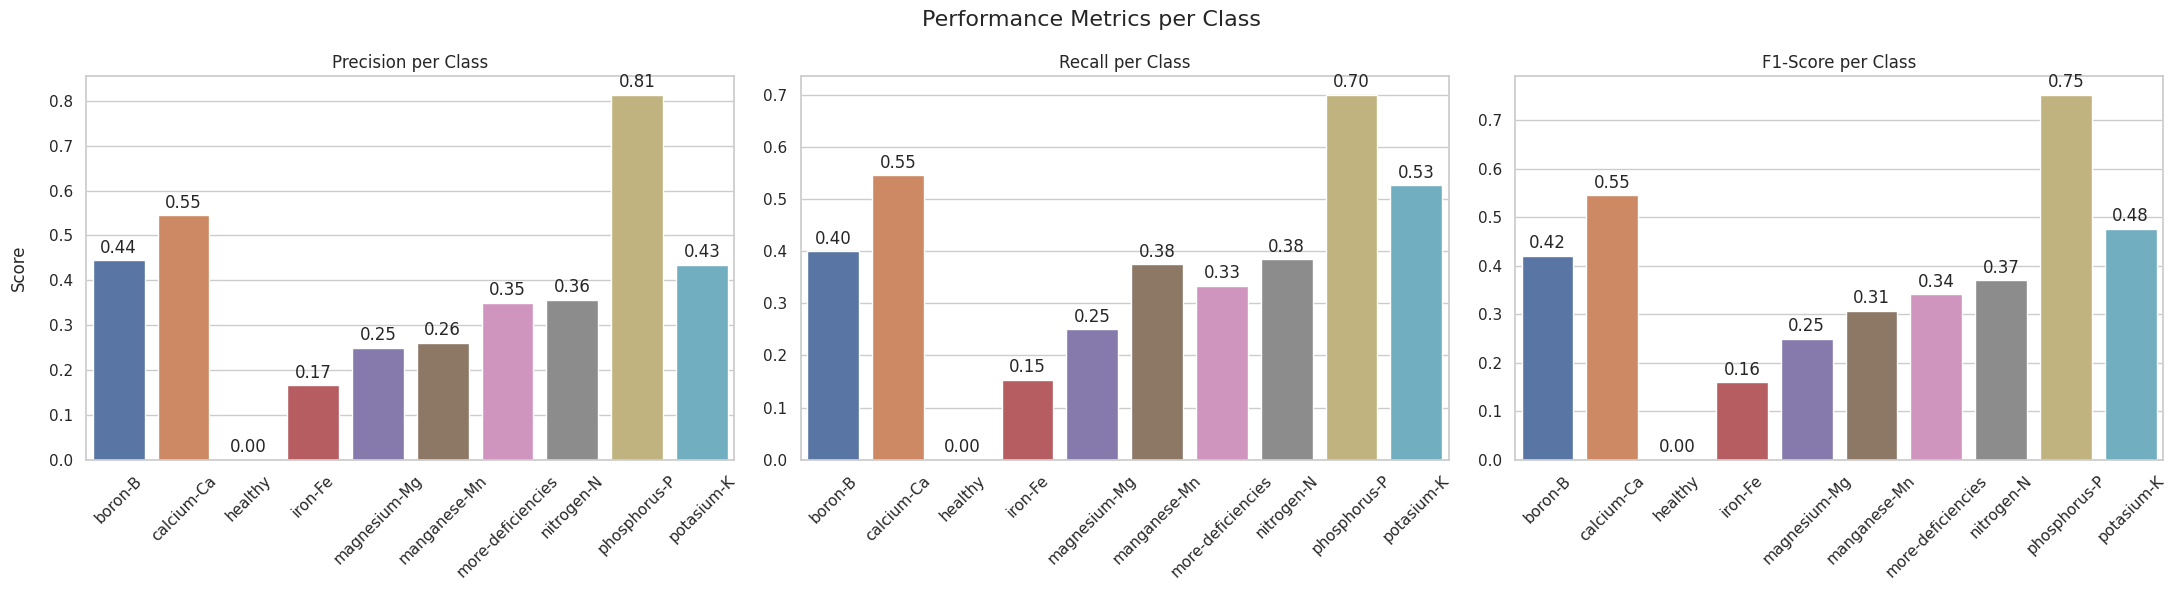

In [ ]:
df_class_metrics = df_metrics.drop('average')

fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Performance Metrics per Class', fontsize=16)

metrics_to_plot = ['precision', 'recall', 'f1']
titles = ['Precision per Class', 'Recall per Class', 'F1-Score per Class']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    
    sns.barplot(
        x=df_class_metrics.index, 
        y=df_class_metrics[metric], 
        ax=ax,
        hue=df_class_metrics.index
    )
    
    ax.set_title(titles[i])
    ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Score', labelpad=15)
    else:
        ax.set_ylabel('')
    
    ax.tick_params(axis='x', rotation=45)
      
    # Add the value on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/metrics_barchart_{MODEL_VERSION}.png"))
plt.show()

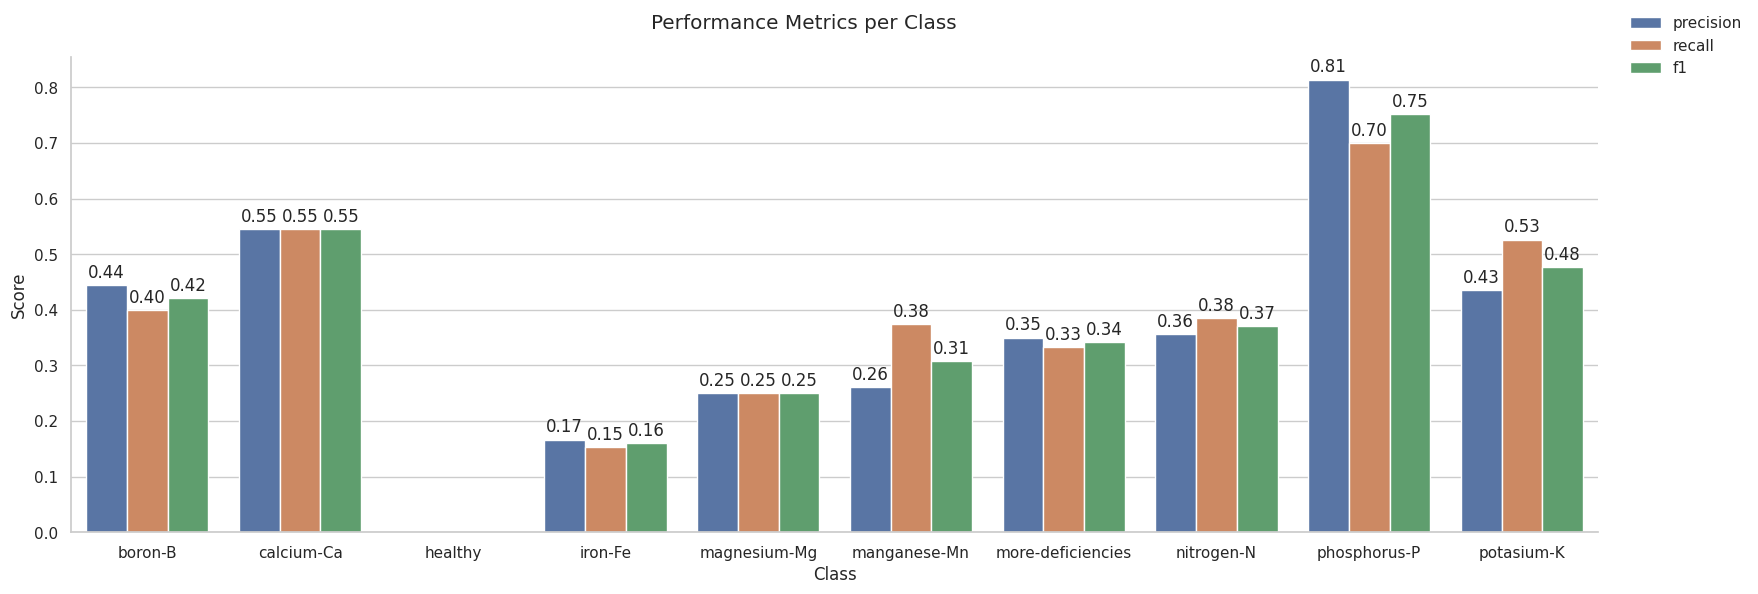

In [87]:
df_class_metrics = df_metrics.drop('average')
df_class_metrics = df_class_metrics.reset_index().rename(columns={'index': 'Class'})

df_melted = pd.melt(
    df_class_metrics,
    id_vars=['Class'],
    value_vars=['precision', 'recall', 'f1'],
    var_name='Metric',
    value_name='Score'
)

g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="Class",
    y="Score",
    hue="Metric",
    aspect=2.5,
    height=6
)

g.figure.suptitle('Performance Metrics per Class')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title=None)

for ax in g.axes.flat:
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.2f}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/metrics_barchart_{MODEL_VERSION}.png"))
plt.show()

### Confusion Matrix

In [ ]:
cm = np.load(os.path.join(OUTPUT_PATH, f"metrics/confusion_matrix_{MODEL_VERSION}.npy"))

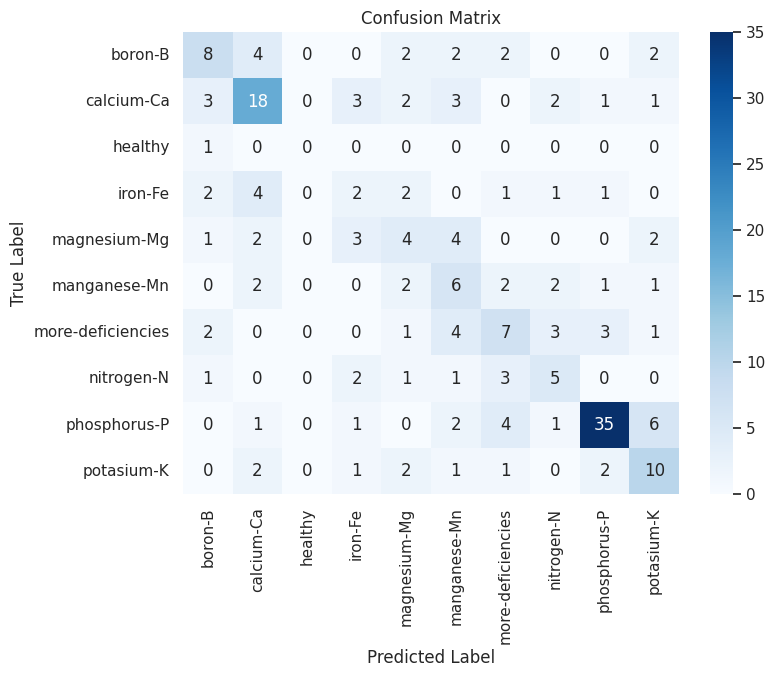

In [46]:
df = pd.DataFrame(cm, columns=classes, index=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(OUTPUT_PATH, f"graphs/confusion_matrix_{MODEL_VERSION}.png"))
plt.show()

### ROC Curve